In this notebook, I attempt to summarize the link performance for a selection of links. Properties displayed include Dashboard throughput, closeness metric, and number of files queued.

In [1]:
#These lines set up inline plotting, and apply a standard size
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 15})

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, exceptions as es_exceptions

#Create instance of ElasticSearch using the Atlas host server
es = Elasticsearch(hosts=[{'host':'es-atlas.cern.ch', 'port':9202}],
                   http_auth=('es-atlas', 'v~$&<J8/cG9]*eQ@'),
                   timeout=60)

Below is a sample list of sites.

In [3]:
sites = ['CERN-PROD','Australia-ATLAS', 'Taiwan-LCG2', 'BEIJING-LCG2','EELA-UTFSM',
         'TOKYO-LCG2','UFlorida-HPC', 'CA-VICTORIA-WESTGRID-T2','ITEP', 'SFU-LCG2','TRIUMF-LCG2']

In [4]:
#Query template

queryTemplate = '''{
  "size": 0,
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "src:%s AND dst:%s",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "range": {
                "timestamp": {
                  "gte": %i,
                  "lte": %i,
                  "format": "epoch_millis"
                }
              }
            }
          ],
          "must_not": []
        }
      }
    }
  },
  "aggs": {
    "2": {
      "date_histogram": {
        "field": "timestamp",
        "interval": "7d",
        "time_zone": "Europe/Berlin",
        "min_doc_count": 1,
        "extended_bounds": {
          "min": %i,
          "max": %i
        }
      },
      "aggs": {
        "1": {
          "avg": {
            "field": "mbps-dashb-1w"
          }
        },
        "2": {
          "avg": {
            "field": "closeness"
          }
        },
        "3": {
          "avg": {
            "field": "queued-total"
          }
        }
      }
    }
  }
}'''

The closeness, Dashboard throughput, and total # of queued files is averaged over a week's time, for each link.

In [5]:
import ast
import time

tic = time.time()

#Convenient time intervals in milliseconds
milliWeek = 7*24*60*60*1000
milliMonth = 30*24*60*60*1000
milliDay = 24*60*60*1000
milliHour = 60*60*1000

currentMilliTime = int(round(time.time()*1000))

start = currentMilliTime - milliWeek
end = currentMilliTime

totalCloseness = []
totalThroughput = []
totalQueued = []

#For each link, aggregate values
for i in range(len(sites)):
    for j in range(len(sites)):
        dashThroughput = []
        closeness = []
        queuedTotal = []
        
        query = ast.literal_eval(queryTemplate%(sites[i],sites[j],start,end,start,end))    
        response = es.search(index="atlas_ddm-metrics*", body=query, request_timeout=600) 
        
        for r in response['aggregations']['2']['buckets']:
            dashThroughput.append(r['1']['value'])
            closeness.append(r['2']['value'])
            queuedTotal.append(r['3']['value'])

        
        totalThroughput.append(np.array(dashThroughput,dtype=np.float))
        totalCloseness.append(np.array(closeness,dtype = np.float))
        totalQueued.append(np.array(queuedTotal,dtype = np.float))
        
toc = time.time()

print('This aggregation over %i X %i links took %f seconds'%(len(sites),len(sites),toc-tic))

This aggregation over 11 X 11 links took 268.708848 seconds


In [12]:
import warnings
#Suppress warnings that occur from trying to take the mean of an empty slice (occurs when 
#no values are present for the current timerange).
warnings.simplefilter("ignore")


#Build grid of numbers for graph
index = 0
dim = len(sites)
t = np.zeros((dim,dim))
c = np.zeros((dim,dim))
f = np.zeros((dim,dim))
for i in range(dim):
    for j in range(dim):
        t[i,j] = np.nanmean(np.array(totalThroughput[index],dtype=float))
        c[i,j] = np.nanmean(np.array(totalCloseness[index],dtype=float))
        f[i,j] = np.nanmean(np.array(totalQueued[index],dtype=float))
        index +=1


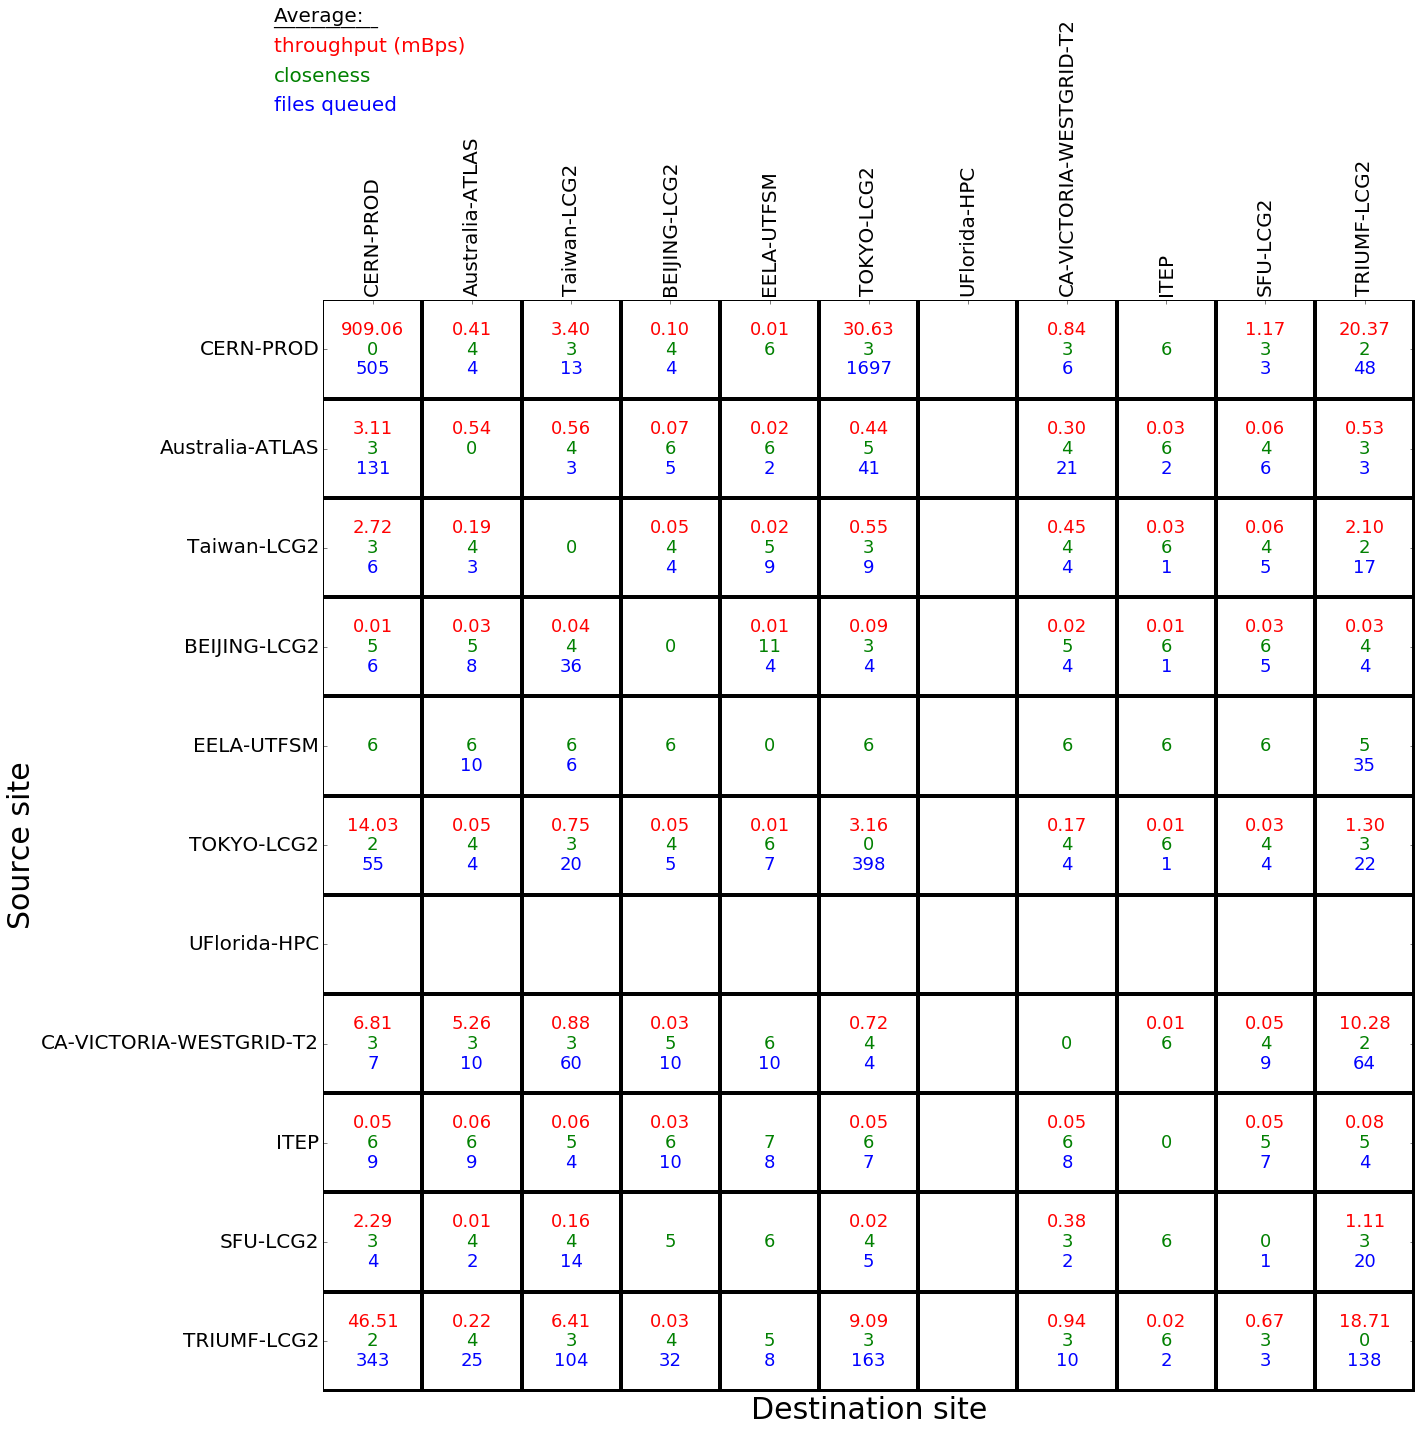

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import AutoMinorLocator



#This blank array can be replaced by an array of meaningful values, and the
#color map may be altered to allow discrete or continuous values to be plotted as cell color.
blankArray = np.zeros((dim,dim))

#Display background as white
cMap = ListedColormap(['white'])
plt.figure(figsize=(20,20))

plt.imshow(blankArray,cmap=cMap,interpolation='none')


#Set numeric labels (if value is not NaN)
for i in range(len(sites)):
    for j in range(len(sites)):
        if np.logical_not(np.isnan(t[i,j])):
            plt.text(i,j-0.2,"%.2f"%(t[i,j]),color='r',size=18,ha='center',va='center')
        if np.logical_not(np.isnan(c[i,j])):
            plt.text(i,j,    "%.0f"%(c[i,j]),color='g',size=18,ha='center',va='center')
        if np.logical_not(np.isnan(f[i,j])):
            plt.text(i,j+0.2,"%.0f"%(f[i,j]),color='b',size=18,ha='center',va='center')


#Manually build legend
plt.text(-1,-3.3,"Average:",color='k',size=20)
plt.text(-1,-3.28,'______________',color='k')
plt.text(-1,-3,  "throughput (mBps)",color='r',size=20)
plt.text(-1,-2.7,"closeness",color='g',size=20)
plt.text(-1,-2.4,"files queued",color='b',size=20)
ax = plt.gca() 

#Draw squares
minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)
ax.yaxis.set_minor_locator(minor_locator)
plt.grid(which='minor',linestyle='-',linewidth=4)

#Set major axis ticks and labels correctly
ax.yaxis.set_ticklabels(sites,size=20)
ax.xaxis.set_ticklabels(sites,size=20)
ax.xaxis.tick_top()

#Rotate labels
plt.yticks(range(dim),rotation=0)
plt.xticks(range(dim),rotation=90)

#Set titles
plt.ylabel('Source site',size=30)
plt.xlabel('Destination site',size=30)
plt.tight_layout()
plt.show()

In [18]:
currentMilliTime = int(round(time.time()*1000))

In [19]:
currentMilliTime

1471349950926